# Reproducing Figure 3

In [6]:
###################
# Import packages #
###################

import numpy as np
from scipy.special import gammainc
from scipy import interpolate
import arviz as az

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Rate definition

In [3]:
rateData_MD = np.load('../data/delayedRateDataMD.npy', allow_pickle=True)[()]
formationRates_MD = rateData_MD['formationRates']
tdelays_MD = rateData_MD['tds']
zformation_MD = rateData_MD['zs']

In [10]:
dz = 0.01
zs = np.arange(0.,10.0,dz) # NOTE: should be same array as what was used to make the delayedRateDataMD.npy file

def R_norm_MD(zs, metMin_td, lambda_td, tdmin):
    fs = gammainc(0.84,(metMin_td**2.)*np.power(10.,0.3*zformation_MD))[...,None]
    weightedFormationRates_MD = formationRates_MD*fs

    dpdt = np.power(tdelays_MD,lambda_td)
    dpdt[tdelays_MD<tdmin] = 0.
    dpdt[tdelays_MD>13.5] = 0.
    mergerRate_MD = weightedFormationRates_MD.dot(dpdt)

    R = mergerRate_MD
    f = interpolate.interp1d(zs, R)
    norm = f(0.2)
    return R, norm

## Loading data

In [7]:
data_CBC_GWB_MD_O3 = az.from_netcdf("../data/O3_CBC_GWB_MD.cdf")
data_CBC_MD_O3 = az.from_netcdf("../data/O3_CBC_MD.cdf")

In [8]:
stacked_samples_CBC_GWB_MD_O3 = data_CBC_GWB_MD_O3.posterior.stack(draws=("chain", "draw"))
stacked_samples_CBC_MD_O3 = data_CBC_MD_O3.posterior.stack(draws=("chain", "draw"))

In [11]:
# Define a grid of effective spins
grid = zs

# Choose a number of traces to draw
nTraces = 1500

# Instantiate an array to hold a collection of traces
p_z_CBC_GWB_MD_O3 = np.zeros((nTraces,grid.size))

# For a random set of posterior samples, compute and store the corresponding probability densities across our grid
random_indices = np.random.choice(np.arange(stacked_samples_CBC_GWB_MD_O3.logR20.size),size=nTraces,replace=False)
for i,ind in enumerate(random_indices):
    if i%100==0:
        print(i)
    td_min = stacked_samples_CBC_GWB_MD_O3.td_min.values[i]
    lambda_td = stacked_samples_CBC_GWB_MD_O3.lambda_td.values[i]
    metMin_td = stacked_samples_CBC_GWB_MD_O3.metMin_td.values[i]
    logR20 = stacked_samples_CBC_GWB_MD_O3.logR20.values[i]
    merger_rate_tmp, rate_02_tmp = R_norm_MD(grid, metMin_td, lambda_td, td_min)
    p_z_CBC_GWB_MD_O3[i,:] = 10**logR20*merger_rate_tmp/rate_02_tmp

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [12]:
# Define a grid of effective spins
grid = zs

# Choose a number of traces to draw
nTraces = 1500

# Instantiate an array to hold a collection of traces
p_z_CBC_MD_O3 = np.zeros((nTraces,grid.size))

# For a random set of posterior samples, compute and store the corresponding probability densities across our grid
random_indices = np.random.choice(np.arange(stacked_samples_CBC_MD_O3.logR20.size),size=nTraces,replace=False)
for i,ind in enumerate(random_indices):
    if i%100==0:
        print(i)
    td_min = stacked_samples_CBC_MD_O3.td_min.values[i]
    lambda_td = stacked_samples_CBC_MD_O3.lambda_td.values[i]
    metMin_td = stacked_samples_CBC_MD_O3.metMin_td.values[i]
    logR20 = stacked_samples_CBC_MD_O3.logR20.values[i]
    merger_rate_tmp, rate_02_tmp = R_norm_MD(grid, metMin_td, lambda_td, td_min)
    p_z_CBC_MD_O3[i,:] = 10**logR20*merger_rate_tmp/rate_02_tmp

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


## Plotting

/tmp/ipykernel_2861522/565476455.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./O3_rate_MD.png",dpi=500)
/tmp/ipykernel_2861522/565476455.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./O3_rate_MD.png",dpi=500)
/tmp/ipykernel_2861522/565476455.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./O3_rate_MD.pdf",dpi=500)
/home/kevin.turbang/.conda/envs/autoregressive-pop-modeling/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


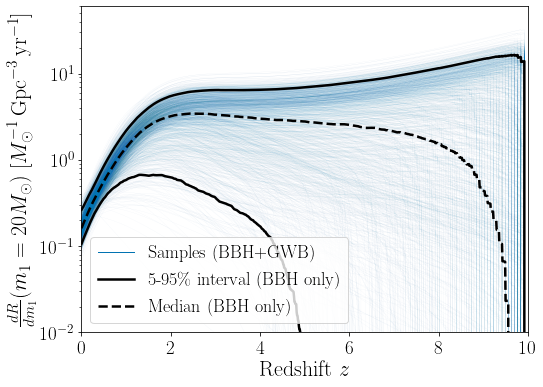

In [27]:
for ii in range(nTraces):
    plt.plot(zs,p_z_CBC_GWB_MD_O3[ii],color=my_palette[0],lw=0.15,alpha=0.1)
plt.plot(10*zs,1e5*p_z_CBC_GWB_MD_O3[nTraces-1],color=my_palette[0],lw=1,alpha=1, label="Samples (BBH+GWB)")  
plt.plot(grid,np.quantile(p_z_CBC_MD_O3,0.05,axis=0),color='k', lw=2.5, alpha=1)
plt.plot(grid,np.quantile(p_z_CBC_MD_O3,0.95,axis=0),color='k',lw=2.5, alpha=1, label="5-95\% interval (BBH only)")
plt.plot(grid,np.median(p_z_CBC_MD_O3,axis=0),color='k', ls='dashed', lw=2.5, alpha=1, label="Median (BBH only)")
plt.yscale("log")
plt.xlabel("Redshift $z$", fontsize=22)
plt.xlim(0,10)
plt.ylim(1e-2,60)
plt.ylabel("$\\frac{dR}{dm_1}(m_1=20M_\\odot)~[M_\\odot^{-1}\,{\\rm Gpc}^{-3}\,{\\rm yr^{-1}}]$", fontsize=22)
plt.legend(fontsize = 18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)